In [1]:
%matplotlib inline

from netCDF4 import Dataset, num2date
from dateutil.parser import *
import os
import numpy as np
import calendar

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import animation

import seaborn as sns

In [2]:
data_file = os.path.join('/Volumes/NiftyDrive/Research/data/air.2m.mon.mean.nc')
with Dataset(data_file) as F:
    dates = num2date(F.variables['time'][:], F.variables['time'].units)
    temps = F.variables['air'][:]
    latitude = F.variables['lat'][:]
    longitude = F.variables['lon'][:]

In [3]:
t0 = 273.15

In [4]:
month = 7
pre = (1900, 1910)
post = (2000, 2010)

In [5]:
month_name = calendar.month_name[month]

In [6]:
lons, lats = np.meshgrid(longitude, latitude)

In [7]:
months = np.array([d.month for d in dates])
years = np.array([d.year for d in dates])

pre_mask = (months == month) & (years >= pre[0]) & (years < pre[1])
post_mask = (months == month) & (years >= post[0]) & (years < post[1])

pre_temps = temps[pre_mask,:,:].mean(axis=0).squeeze() - t0
post_temps = temps[post_mask,:,:].mean(axis=0).squeeze() - t0

delta_t = post_temps - pre_temps
delta_t.shape

(94, 192)

In [8]:
temps[pre_mask,:,:].shape

(10, 94, 192)

In [9]:
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower ofset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax/(vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highets point in the colormap's range.
          Defaults to 1.0 (no upper ofset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

def make_basemap(ax):
    m = Basemap(ax=ax, projection='robin', lon_0=0, resolution='c')
    m.drawcoastlines()
    m.drawparallels(np.arange(-90.,99.,30.))
    m.drawmeridians(np.arange(-180.,180.,60.))
    
    return m, ax

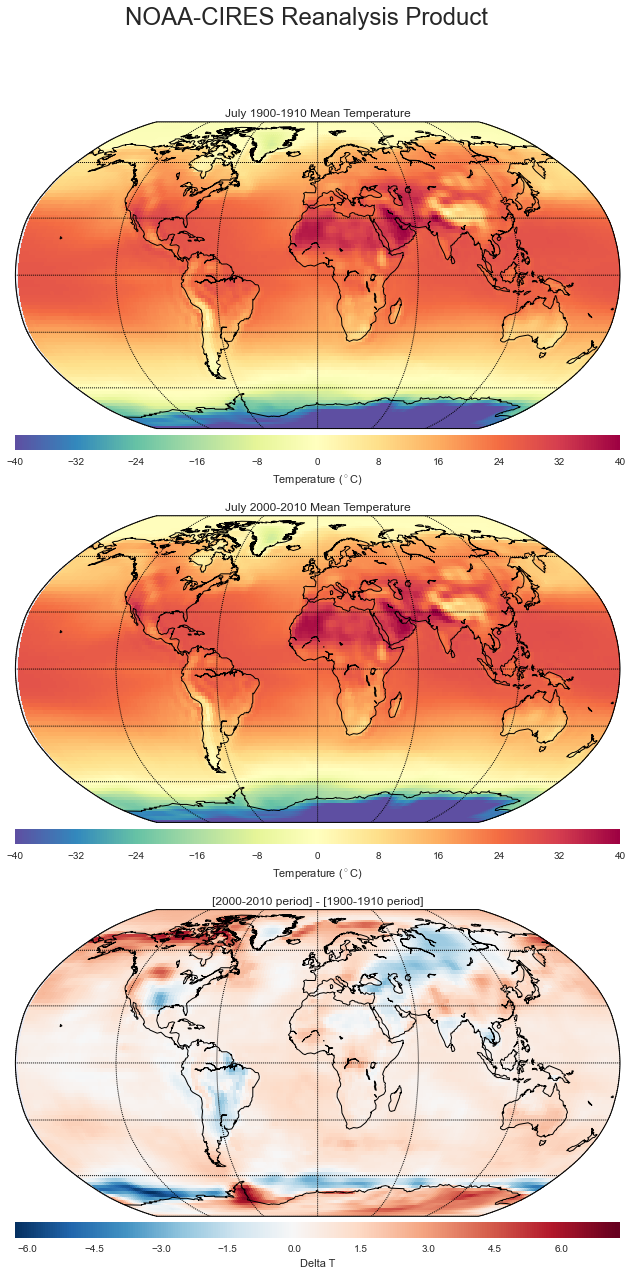

In [10]:
fig, ax = plt.subplots(3, figsize=(13, 20))

fig.suptitle('NOAA-CIRES Reanalysis Product', fontsize=24)

m, ax[0] = make_basemap(ax[0])
im = m.pcolormesh(lons, lats, pre_temps, latlon=True,
                  vmin=-40, vmax=40, cmap=cm.Spectral_r)
cb = m.colorbar(im, 'bottom', size='5%', pad='2%')
cb.set_label('Temperature ($^\circ$C)')
ax[0].set_title("{} {}-{} Mean Temperature".format(month_name, pre[0], pre[1]))

m, ax[1] = make_basemap(ax[1])
im = m.pcolormesh(lons, lats, post_temps, latlon=True,
                  vmin=-40, vmax=40, cmap=cm.Spectral_r)
cb = m.colorbar(im, 'bottom', size='5%', pad='2%')
cb.set_label('Temperature ($^\circ$C)')
ax[1].set_title("{} {}-{} Mean Temperature".format(month_name, post[0], post[1]))

m, ax[2] = make_basemap(ax[2])
midpoint = abs(min(delta_t.ravel())) / (max(delta_t.ravel()) - min(delta_t.ravel()))
im = m.pcolormesh(lons, lats, delta_t, latlon=True, 
                  cmap=shiftedColorMap(cm.RdBu_r, midpoint=midpoint))
cb = m.colorbar(im, 'bottom', size='5%', pad='2%')
cb.set_label('Delta T')
ax[2].set_title("[{}-{} period] - [{}-{} period]"
                .format(post[0], post[1], pre[0], pre[1]))

#fig.tight_layout()

figname = 'NOAA/{}_{}-{}.png'.format(month_name, pre[0], post[1])
fig.savefig(figname, dpi=300)

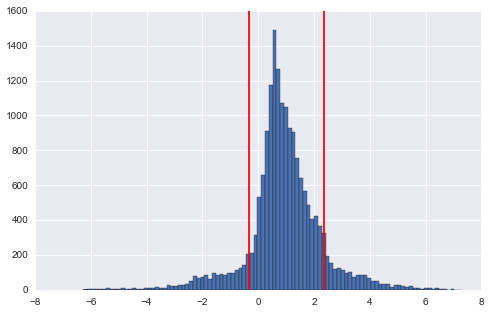

In [11]:
fig, ax = plt.subplots(figsize=(8, 5))

counts, bins, patches = ax.hist(delta_t.ravel(), bins=100)
upper_percentile = np.percentile(delta_t.ravel(), 90)
lower_percentile = np.percentile(delta_t.ravel(), 10)
ax.plot([upper_percentile, upper_percentile], ax.get_ylim(), 'r-')
ax.plot([lower_percentile, lower_percentile], ax.get_ylim(), 'r-')

fig.savefig('NOAA/{}_deltaT_hist.png'.format(month_name))

In [12]:
# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_axes([0.1, 0.05, 0.8, 0.8])
# m, ax = make_basemap(ax)

# upper_data = np.ma.masked_less(delta_t, upper_percentile)
# lower_data = np.ma.masked_greater(delta_t, lower_percentile)

# um = m.pcolormesh(lons, lats, upper_data, latlon=True, cmap=cm.Reds,)
#                  #vmin=upper_percentile, vmax=max(delta_t.ravel()))

# lm = m.pcolormesh(lons, lats, lower_data, latlon=True, cmap=cm.Blues_r,)
#                  #vmin=min(delta_t.ravel()), vmax=lower_percentile)
# ucax = fig.add_axes([.51, .05, .39, .02])
# ucb = fig.colorbar(um, cax=ucax, orientation='horizontal', )

# lcax = fig.add_axes([.1, .05, .39, .02])
# lcb = fig.colorbar(lm, cax=lcax, orientation='horizontal')

In [13]:
# fig, ax = plt.subplots(figsize=(15, 12))

# m = Basemap(ax=ax, projection='robin', lon_0=0, resolution='c')
# m.drawcoastlines()
# m.drawparallels(np.arange(-90.,99.,30.))
# m.drawmeridians(np.arange(-180.,180.,60.))
# im = m.pcolormesh(lons, lats, temps[0,:,:].squeeze()-t0, latlon=True,
#                   vmin=-40, vmax=40)
# cb = m.colorbar(im, 'bottom', size='5%', pad='2%', ax=ax)
# cb.set_label('Temperature ($^\circ$C)')

# def init():
#     im.set_array([])
#     ax.set_title('')
#     return im, ax

# def animate(i):
#     t = m.pcolormesh(lons, lats, temps[i,:,:].squeeze()-t0, latlon=True, vmin=-40, vmax=40)
#     im.set_array(t.get_array())
#     ax.set_title("2 meter Surface Temperature\n{}".format(dates[i].strftime('%Y %b')))
    
#     return im, ax

# anim = animation.FuncAnimation(fig, animate, init_func=init,
#                                frames=len(dates), interval=1)
# anim.save('1990-2010_Temperature_Map.mp4', fps=12, extra_args=['-vcodec', 'libx264'])